In [73]:
#imports to work with...
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from cl_framework.continual_learning.models.BaseModel import BaseModel

from cl_framework.dataset.dataset_utils import get_dataset
from tqdm import tqdm

In [27]:
# this is used later to create the class_to_idx
def kinetics_classes(classes_csv):
    df = pd.read_csv(classes_csv)
    classes_behaviors = {}

    for _, row in df.iterrows():
        class_name = row['Category']
        subcategory = row['Subcategory']
        
        # Check if the class_name is already in the dictionary, if not, create a new entry
        if class_name not in classes_behaviors:
            classes_behaviors[class_name] = []
        
        # Add the subcategory to the corresponding class_name entry in the dictionary
        classes_behaviors[class_name].append(subcategory)

    return classes_behaviors

In [28]:
#create a mapping between classes - behaviors
folder_csv = '../Kinetics/Info/'
class_csv = os.path.join(folder_csv, 'classes.csv')
classes_behaviors = kinetics_classes(class_csv)

#create a index for each class -- {class: idx}
class_to_idx = {key: i for i, key in enumerate(classes_behaviors.keys())}


In [29]:
predictions_names = ['food', 'phone','smoking','fatigue','selfcare']

all_behaviors_dict = {
    'food': [
        'eating burger', 'eating cake', 'eating carrots', 'eating chips', 'eating doughnuts',
        'eating hotdog', 'eating ice cream', 'eating spaghetti', 'eating watermelon',
        'sucking lolly', 'tasting beer', 'tasting food', 'tasting wine', 'sipping cup'
    ],
    'phone': [
        'texting', 'talking on cell phone', 'looking at phone'
    ],
    'smoking': [
        'smoking', 'smoking hookah', 'smoking pipe'
    ],
    'fatigue': [
        'sleeping', 'yawning', 'headbanging', 'headbutting', 'shaking head'
    ],
    'selfcare': [
        'scrubbing face', 'putting in contact lenses', 'putting on eyeliner', 'putting on foundation',
        'putting on lipstick', 'putting on mascara', 'brushing hair', 'brushing teeth', 'braiding hair',
        'combing hair', 'dyeing eyebrows', 'dyeing hair'
    ]
    }


n_task = 6
total_classes = 5

In [30]:
#load dataset and create dataloader
pretrained_path = 'not_none'
data_path = '../Kinetics'
dataset = 'kinetics'
test_set, _, _, total_classes, subcat_dict = get_dataset(dataset, data_path, pretrained_path)
test_loaders = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4)
device = "cuda:" + str(0)

Loading Kinetics


In [76]:
#Instantiate a model
backbone = 'movinetA0'
model = BaseModel(backbone=backbone, dataset=dataset)
model.add_classification_head(total_classes)

subcategories  = [
        'eating burger', 'eating cake', 'eating carrots', 'eating chips', 'eating doughnuts',
        'eating hotdog', 'eating ice cream', 'eating spaghetti', 'eating watermelon',
        'sucking lolly', 'tasting beer', 'tasting food', 'tasting wine', 'sipping cup',

        'texting', 'talking on cell phone', 'looking at phone',

        'smoking', 'smoking hookah', 'smoking pipe',

        'sleeping', 'yawning', 'headbanging', 'headbutting', 'shaking head',

        'scrubbing face', 'putting in contact lenses', 'putting on eyeliner', 'putting on foundation',
        'putting on lipstick', 'putting on mascara', 'brushing hair', 'brushing teeth', 'braiding hair',
        'combing hair', 'dyeing eyebrows', 'dyeing hair',
]

class_idx_feat = {v:i for i, v in enumerate(subcategories)}


model_path = '../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/'
#model_path = '../runs_trainings/from_checkpoint_sgd/lwf/incremental_decremental/seed_0/incdec_lwf_J8ASoD3F/'

In [32]:
task_feat_list = []
for i in range(6):
    #Load checkpoint and model
    out_path = os.path.join(model_path,'best_mAP_task_{}_model.pth'.format(i))
    model.load_state_dict(torch.load(out_path, map_location=device))
    print("Model Loaded {}".format(out_path))

    feature_list = [] 
    subcat_list = []
    target_list = [] 
    model.eval()
    model.to(device)
    for batch_idx, (images, targets, _, subcat, _) in enumerate(tqdm(test_loaders)):
        with torch.no_grad():
            images = images.to(device)
            _, features = model(images)
            features = features.view(1, 2048) 
            feature_list.append(features.detach().cpu())
            subcat_list.append(subcat[0])
            target_list.append(class_idx_feat[subcat[0]])
    
    feature_list = torch.cat(feature_list, dim=0)
    target_list = torch.tensor(target_list)
    task_feat_list.append(feature_list)

task_feat_list = torch.stack(task_feat_list, dim=0)

Model Loaded ../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/best_mAP_task_0_model.pth


100%|██████████| 3700/3700 [01:28<00:00, 41.89it/s]


Model Loaded ../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/best_mAP_task_1_model.pth


100%|██████████| 3700/3700 [01:27<00:00, 42.28it/s]


Model Loaded ../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/best_mAP_task_2_model.pth


100%|██████████| 3700/3700 [01:27<00:00, 42.11it/s]


Model Loaded ../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/best_mAP_task_3_model.pth


100%|██████████| 3700/3700 [01:27<00:00, 42.20it/s]


Model Loaded ../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/best_mAP_task_4_model.pth


100%|██████████| 3700/3700 [01:28<00:00, 41.94it/s]


Model Loaded ../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/seed_0/incdec_1GM3Q6GN/best_mAP_task_5_model.pth


100%|██████████| 3700/3700 [01:28<00:00, 42.04it/s]


In [38]:
feature_save_path = os.path.join(model_path,'features_tensors')
if not os.path.exists(feature_save_path):
    os.mkdir(feature_save_path)
torch.save(task_feat_list, os.path.join(feature_save_path,'features_tensor.pt'))
torch.save(target_list, os.path.join(feature_save_path,'target_tensor.pt'))

In [77]:

feature_save_path = os.path.join(model_path,'features_tensors')
features = torch.load(os.path.join(feature_save_path,'features_tensor.pt'), weights_only=True)
targets = torch.load(os.path.join(feature_save_path,'target_tensor.pt'), weights_only=True)
print(features.shape)
print(targets.shape)

torch.Size([6, 3700, 2048])
torch.Size([3700])


In [78]:
task = 5
selected_features = features[task]
print(selected_features.shape)

selected_subcategories = all_behaviors_dict['fatigue']
idx_selected = []
for subcat_name in selected_subcategories:

    idx_sel = np.where(targets == class_idx_feat[subcat_name])[0]
    idx_selected.extend(idx_sel.tolist())


selected_features = selected_features[idx_selected]
print(selected_features.shape)
selected_targets = targets[idx_selected]
print(selected_targets.shape)

torch.Size([3700, 2048])
torch.Size([500, 2048])
torch.Size([500])


In [70]:
#make t-SNE
features = np.array(selected_features)
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, perplexity=50, random_state=0, n_iter=5000)
feat_tsne = tsne.fit_transform(selected_features)

/home/caselli/miniconda3/envs/data_incdec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/caselli/miniconda3/envs/data_incdec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [79]:
#make pca
features = np.array(selected_features)
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)

tsne = PCA(n_components=2, random_state=0)
feat_tsne = tsne.fit_transform(selected_features)

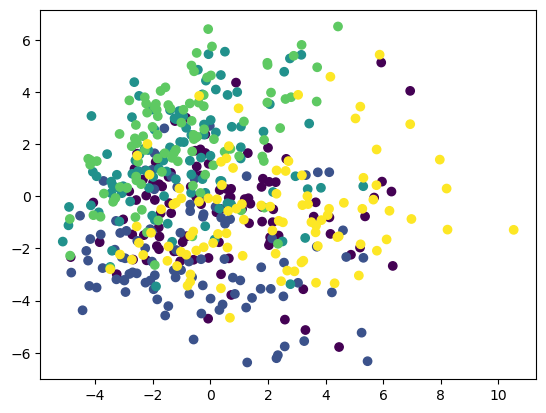

In [75]:
import matplotlib.pyplot as plt 

plt.scatter(x=feat_tsne[:, 0], y=feat_tsne[:, 1], c=selected_targets)
plt.show()
# fig.update_layout(
#     title="t-SNE visualization of Customer Churn dataset",
#     xaxis_title="First t-SNE",
#     yaxis_title="Second t-SNE",
# )
 

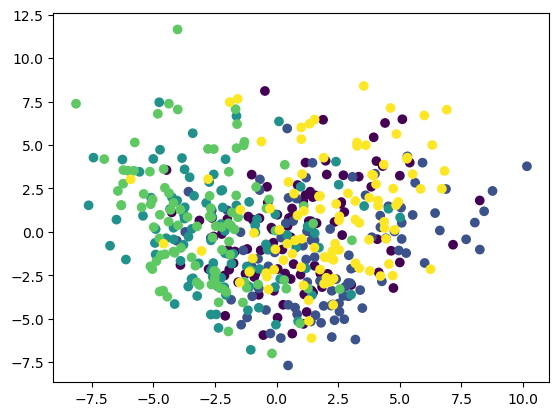

In [80]:
import matplotlib.pyplot as plt 

plt.scatter(x=feat_tsne[:, 0], y=feat_tsne[:, 1], c=selected_targets)
plt.show()
# fig.update_layout(
#     title="t-SNE visualization of Customer Churn dataset",
#     xaxis_title="First t-SNE",
#     yaxis_title="Second t-SNE",
# )
 

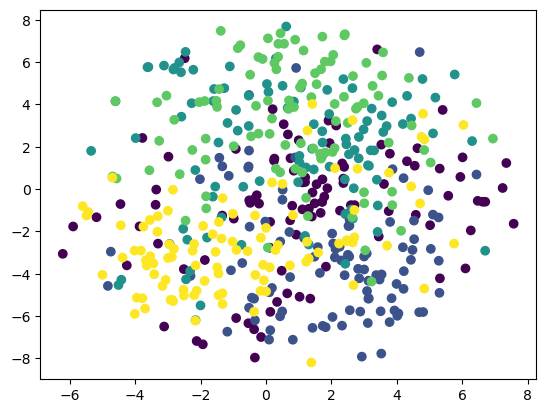

In [66]:
import matplotlib.pyplot as plt 

plt.scatter(x=feat_tsne[:, 0], y=feat_tsne[:, 1], c=selected_targets)
plt.show()
# fig.update_layout(
#     title="t-SNE visualization of Customer Churn dataset",
#     xaxis_title="First t-SNE",
#     yaxis_title="Second t-SNE",
# )
 

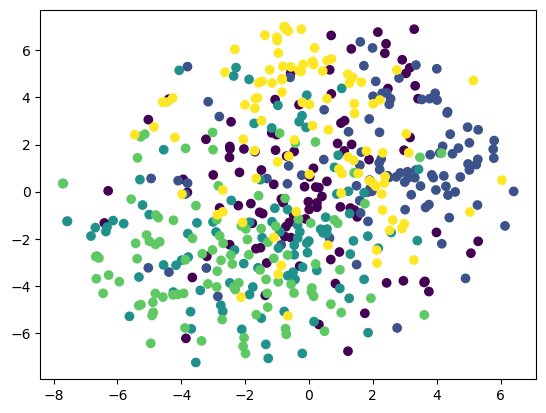

In [71]:
import matplotlib.pyplot as plt 

plt.scatter(x=feat_tsne[:, 0], y=feat_tsne[:, 1], c=selected_targets)
plt.show()
# fig.update_layout(
#     title="t-SNE visualization of Customer Churn dataset",
#     xaxis_title="First t-SNE",
#     yaxis_title="Second t-SNE",
# )
 